<img src="https://raw.githubusercontent.com/sokrypton/ColabFold/main/.github/ColabFold_Marv_Logo_Small.png" height="200" align="right" style="height:240px">

##ColabFold v1.5.2-patch: AlphaFold2 using MMseqs2

Easy to use protein structure and complex prediction using [AlphaFold2](https://www.nature.com/articles/s41586-021-03819-2) and [Alphafold2-multimer](https://www.biorxiv.org/content/10.1101/2021.10.04.463034v1). Sequence alignments/templates are generated through [MMseqs2](mmseqs.com) and [HHsearch](https://github.com/soedinglab/hh-suite). For more details, see <a href="#Instructions">bottom</a> of the notebook, checkout the [ColabFold GitHub](https://github.com/sokrypton/ColabFold) and read our manuscript.
Old versions: [v1.4](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.4.0/AlphaFold2.ipynb), [v1.5.1](https://colab.research.google.com/github/sokrypton/ColabFold/blob/v1.5.1/AlphaFold2.ipynb)

[Mirdita M, Schütze K, Moriwaki Y, Heo L, Ovchinnikov S, Steinegger M. ColabFold: Making protein folding accessible to all.
*Nature Methods*, 2022](https://www.nature.com/articles/s41592-022-01488-1)

-----------

### News
- <b><font color='green'>2023/07/31: The ColabFold MSA server is back to normal. It was using older DB (UniRef30 2202/PDB70 220313) from 27th ~8:30 AM CEST to 31st ~11:10 AM CEST.</font></b>
- <b><font color='green'>2023/06/12: New databases! UniRef30 updated to 2023_02 and PDB to 230517. We now use PDB100 instead of PDB70 (see [notes](#pdb100)).</font></b>
- <b><font color='green'>2023/06/12: We introduced a new default pairing strategy: Previously, for multimer predictions with more than 2 chains, we only pair if all sequences taxonomically match ("complete" pairing). The new default "greedy" strategy pairs any taxonomically matching subsets.</font></b>

In [ ]:
#@title Input protein sequence(s), then hit `Runtime` -> `Run all`
from google.colab import files
import os
import re
import hashlib
import random

from sys import version_info
python_version = f"{version_info.major}.{version_info.minor}"

def add_hash(x,y):
  return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

query_sequence = 'SPCPQAWGPPGVQYGQPGRSVKLCCPGVTAGDPVSWFRDGEPKLLQGPDSGLGHELVLAQADSTDEGTYICQTLDGALGGTVTLQLGYPPARPVVSCQAADYENFSCTWSPSQISGLPTRYLTSYRKKTVLGADSQRRSPSTGPWPCPQDPLGAARCVVHGAEFWSQYRINVTEVNPLGASTRLLDVSLQSILRPDPPQGLRVESVPGYPRRLRASWTYPASWPSQPHFLLKFRLQYRPAQHPAWSTVEPAGLEEVITDAVAGLPHAVRVSARDFLDAGTWSTWSTWSPEAWGTPS' #@param {type:"string"}
#@markdown  - Use `:` to specify inter-protein chainbreaks for **modeling complexes** (supports homo- and hetro-oligomers). For example **PI...SK:PI...SK** for a homodimer
jobname = 'IL11R_T306_S308dup' #@param {type:"string"}
# number of models to use
num_relax = 0 #@param [0, 1, 5] {type:"raw"}
#@markdown - specify how many of the top ranked structures to relax using amber
template_mode = "none" #@param ["none", "pdb100","custom"]
#@markdown - `none` = no template information is used. `pdb100` = detect templates in pdb100 (see [notes](#pdb100)). `custom` - upload and search own templates (PDB or mmCIF format, see [notes](#custom_templates))

use_amber = num_relax > 0

# remove whitespaces
query_sequence = "".join(query_sequence.split())

basejobname = "".join(jobname.split())
basejobname = re.sub(r'\W+', '', basejobname)
jobname = add_hash(basejobname, query_sequence)

# check if directory with jobname exists
def check(folder):
  if os.path.exists(folder):
    return False
  else:
    return True
if not check(jobname):
  n = 0
  while not check(f"{jobname}_{n}"): n += 1
  jobname = f"{jobname}_{n}"

# make directory to save results
os.makedirs(jobname, exist_ok=True)

# save queries
queries_path = os.path.join(jobname, f"{jobname}.csv")
with open(queries_path, "w") as text_file:
  text_file.write(f"id,sequence\n{jobname},{query_sequence}")

if template_mode == "pdb100":
  use_templates = True
  custom_template_path = None
elif template_mode == "custom":
  custom_template_path = os.path.join(jobname,f"template")
  os.makedirs(custom_template_path, exist_ok=True)
  uploaded = files.upload()
  use_templates = True
  for fn in uploaded.keys():
    os.rename(fn,os.path.join(custom_template_path,fn))
else:
  custom_template_path = None
  use_templates = False

print("jobname",jobname)
print("sequence",query_sequence)
print("length",len(query_sequence.replace(":","")))



In [ ]:
#@title Install dependencies
%%time
import os
USE_AMBER = use_amber
USE_TEMPLATES = use_templates
PYTHON_VERSION = python_version

if not os.path.isfile("COLABFOLD_READY"):
  print("installing colabfold...")
  os.system("pip install -q --no-warn-conflicts 'colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold'")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold")
  os.system("ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold")
  # patch for jax > 0.3.25
  os.system("sed -i 's/weights = jax.nn.softmax(logits)/logits=jnp.clip(logits,-1e8,1e8);weights=jax.nn.softmax(logits)/g' alphafold/model/modules.py")
  os.system("touch COLABFOLD_READY")

if USE_AMBER or USE_TEMPLATES:
  if not os.path.isfile("CONDA_READY"):
    print("installing conda...")
    os.system("wget -qnc https://github.com/conda-forge/miniforge/releases/latest/download/Mambaforge-Linux-x86_64.sh")
    os.system("bash Mambaforge-Linux-x86_64.sh -bfp /usr/local")
    os.system("mamba config --set auto_update_conda false")
    os.system("touch CONDA_READY")

if USE_TEMPLATES and not os.path.isfile("HH_READY") and USE_AMBER and not os.path.isfile("AMBER_READY"):
  print("installing hhsuite and amber...")
  os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
  os.system("touch HH_READY")
  os.system("touch AMBER_READY")
else:
  if USE_TEMPLATES and not os.path.isfile("HH_READY"):
    print("installing hhsuite...")
    os.system(f"mamba install -y -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python='{PYTHON_VERSION}'")
    os.system("touch HH_READY")
  if USE_AMBER and not os.path.isfile("AMBER_READY"):
    print("installing amber...")
    os.system(f"mamba install -y -c conda-forge openmm=7.7.0 python='{PYTHON_VERSION}' pdbfixer")
    os.system("touch AMBER_READY")

In [ ]:
#@markdown ### MSA options (custom MSA upload, single sequence, pairing mode)
msa_mode = "mmseqs2_uniref_env" #@param ["mmseqs2_uniref_env", "mmseqs2_uniref","single_sequence","custom"]
pair_mode = "unpaired_paired" #@param ["unpaired_paired","paired","unpaired"] {type:"string"}
#@markdown - "unpaired_paired" = pair sequences from same species + unpaired MSA, "unpaired" = seperate MSA for each chain, "paired" - only use paired sequences.

# decide which a3m to use
if "mmseqs2" in msa_mode:
  a3m_file = os.path.join(jobname,f"{jobname}.a3m")

elif msa_mode == "custom":
  a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
  if not os.path.isfile(a3m_file):
    custom_msa_dict = files.upload()
    custom_msa = list(custom_msa_dict.keys())[0]
    header = 0
    import fileinput
    for line in fileinput.FileInput(custom_msa,inplace=1):
      if line.startswith(">"):
         header = header + 1
      if not line.rstrip():
        continue
      if line.startswith(">") == False and header == 1:
         query_sequence = line.rstrip()
      print(line, end='')

    os.rename(custom_msa, a3m_file)
    queries_path=a3m_file
    print(f"moving {custom_msa} to {a3m_file}")

else:
  a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
  with open(a3m_file, "w") as text_file:
    text_file.write(">1\n%s" % query_sequence)

In [ ]:
#@markdown ### Advanced settings
model_type = "auto" #@param ["auto", "alphafold2_ptm", "alphafold2_multimer_v1", "alphafold2_multimer_v2", "alphafold2_multimer_v3"]
#@markdown - if `auto` selected, will use `alphafold2_ptm` for monomer prediction and `alphafold2_multimer_v3` for complex prediction.
#@markdown Any of the mode_types can be used (regardless if input is monomer or complex).
num_recycles = "auto" #@param ["auto", "0", "1", "3", "6", "12", "24", "48"]
recycle_early_stop_tolerance = "auto" #@param ["auto", "0.0", "0.5", "1.0"]
#@markdown - if `auto` selected, will use 20 recycles if `model_type=alphafold2_multimer_v3` (with tol=0.5), all else 3 recycles (with tol=0.0).
pairing_strategy = "greedy" #@param ["greedy", "complete"] {type:"string"}
#@markdown - `greedy` = pair any taxonomically matching subsets, `complete` = all sequences have to match in one line.


#@markdown #### Sample settings
#@markdown -  enable dropouts and increase number of seeds to sample predictions from uncertainty of the model.
#@markdown -  decrease `max_msa` to increase uncertainity
max_msa = "auto" #@param ["auto", "512:1024", "256:512", "64:128", "32:64", "16:32"]
num_seeds = 1 #@param [1,2,4,8,16] {type:"raw"}
use_dropout = False #@param {type:"boolean"}

num_recycles = None if num_recycles == "auto" else int(num_recycles)
recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
if max_msa == "auto": max_msa = None

#@markdown #### Save settings
save_all = False #@param {type:"boolean"}
save_recycles = False #@param {type:"boolean"}
save_to_google_drive = False #@param {type:"boolean"}
#@markdown -  if the save_to_google_drive option was selected, the result zip will be uploaded to your Google Drive
dpi = 200 #@param {type:"integer"}
#@markdown - set dpi for image resolution

if save_to_google_drive:
  from pydrive.drive import GoogleDrive
  from pydrive.auth import GoogleAuth
  from google.colab import auth
  from oauth2client.client import GoogleCredentials
  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)
  print("You are logged into Google Drive and are good to go!")

#@markdown Don't forget to hit `Runtime` -> `Run all` after updating the form.

In [ ]:
#@title Run Prediction
display_images = True #@param {type:"boolean"}

import sys
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from Bio import BiopythonDeprecationWarning
warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
from pathlib import Path
from colabfold.download import download_alphafold_params, default_data_dir
from colabfold.utils import setup_logging
from colabfold.batch import get_queries, run, set_model_type
from colabfold.plot import plot_msa_v2

import os
import numpy as np
try:
  K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
except:
  K80_chk = "0"
  pass
if "1" in K80_chk:
  print("WARNING: found GPU Tesla K80: limited to total length < 1000")
  if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
    del os.environ["TF_FORCE_UNIFIED_MEMORY"]
  if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
    del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

from colabfold.colabfold import plot_protein
from pathlib import Path
import matplotlib.pyplot as plt

# For some reason we need that to get pdbfixer to import
if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
    sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

def input_features_callback(input_features):
  if display_images:
    plot_msa_v2(input_features)
    plt.show()
    plt.close()

def prediction_callback(protein_obj, length,
                        prediction_result, input_features, mode):
  model_name, relaxed = mode
  if not relaxed:
    if display_images:
      fig = plot_protein(protein_obj, Ls=length, dpi=150)
      plt.show()
      plt.close()

result_dir = jobname
log_filename = os.path.join(jobname,"log.txt")
if not os.path.isfile(log_filename) or 'logging_setup' not in globals():
  setup_logging(Path(log_filename))
  logging_setup = True

queries, is_complex = get_queries(queries_path)
model_type = set_model_type(is_complex, model_type)

if "multimer" in model_type and max_msa is not None:
  use_cluster_profile = False
else:
  use_cluster_profile = True

download_alphafold_params(model_type, Path("."))
results = run(
    queries=queries,
    result_dir=result_dir,
    use_templates=use_templates,
    custom_template_path=custom_template_path,
    num_relax=num_relax,
    msa_mode=msa_mode,
    model_type=model_type,
    num_models=5,
    num_recycles=num_recycles,
    recycle_early_stop_tolerance=recycle_early_stop_tolerance,
    num_seeds=num_seeds,
    use_dropout=use_dropout,
    model_order=[1,2,3,4,5],
    is_complex=is_complex,
    data_dir=Path("."),
    keep_existing_results=False,
    rank_by="auto",
    pair_mode=pair_mode,
    pairing_strategy=pairing_strategy,
    stop_at_score=float(100),
    prediction_callback=prediction_callback,
    dpi=dpi,
    zip_results=False,
    save_all=save_all,
    max_msa=max_msa,
    use_cluster_profile=use_cluster_profile,
    input_features_callback=input_features_callback,
    save_recycles=save_recycles,
)
results_zip = f"{jobname}.result.zip"
os.system(f"zip -r {results_zip} {jobname}")

In [ ]:
#@title Display 3D structure {run: "auto"}
import py3Dmol
import glob
import matplotlib.pyplot as plt
from colabfold.colabfold import plot_plddt_legend
from colabfold.colabfold import pymol_color_list, alphabet_list
rank_num = 1 #@param ["1", "2", "3", "4", "5"] {type:"raw"}
color = "lDDT" #@param ["chain", "lDDT", "rainbow"]
show_sidechains = False #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

tag = results["rank"][0][rank_num - 1]
jobname_prefix = ".custom" if msa_mode == "custom" else ""
pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
pdb_file = glob.glob(pdb_filename)

def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
  model_name = f"rank_{rank_num}"
  view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
  view.addModel(open(pdb_file[0],'r').read(),'pdb')

  if color == "lDDT":
    view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
  elif color == "rainbow":
    view.setStyle({'cartoon': {'color':'spectrum'}})
  elif color == "chain":
    chains = len(queries[0][1]) + 1 if is_complex else 1
    for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
       view.setStyle({'chain':chain},{'cartoon': {'color':color}})

  if show_sidechains:
    BB = ['C','O','N']
    view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                        {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
    view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                        {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
  if show_mainchains:
    BB = ['C','O','N','CA']
    view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

  view.zoomTo()
  return view

show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
if color == "lDDT":
  plot_plddt_legend().show()

In [ ]:
#@title Plots {run: "auto"}
from IPython.display import display, HTML
import base64
from html import escape

# see: https://stackoverflow.com/a/53688522
def image_to_data_url(filename):
  ext = filename.split('.')[-1]
  prefix = f'data:image/{ext};base64,'
  with open(filename, 'rb') as f:
    img = f.read()
  return prefix + base64.b64encode(img).decode('utf-8')

pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
display(HTML(f"""
<style>
  img {{
    float:left;
  }}
  .full {{
    max-width:100%;
  }}
  .half {{
    max-width:50%;
  }}
  @media (max-width:640px) {{
    .half {{
      max-width:100%;
    }}
  }}
</style>
<div style="max-width:90%; padding:2em;">
  <h1>Plots for {escape(jobname)}</h1>
  <img src="{pae}" class="full" />
  <img src="{cov}" class="half" />
  <img src="{plddt}" class="half" />
</div>
"""))


In [ ]:
#@title Package and download results
#@markdown If you are having issues downloading the result archive, try disabling your adblocker and run this cell again. If that fails click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

if msa_mode == "custom":
  print("Don't forget to cite your custom MSA generation method.")

files.download(f"{jobname}.result.zip")

if save_to_google_drive == True and drive:
  uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
  uploaded.SetContentFile(f"{jobname}.result.zip")
  uploaded.Upload()
  print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

In [2]:
#@title ### Installing GROMACS 2020.6 version
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs.tar.gz
!tar xzf gromacs.tar.gz
# It is recommended (and required for GROMACS 2021) to upgrade cmake
!pip install cmake --upgrade

--2023-08-04 06:40:50--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/software/gromacs.tar.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35608971 (34M) [application/octet-stream]
Saving to: ‘gromacs.tar.gz’

gromacs.tar.gz      100%[===================>]  33.96M  --.-KB/s    in 0.07s   

2023-08-04 06:40:53 (463 MB/s) - ‘gromacs.tar.gz’ saved [35608971/35608971]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.0/26.0 MB 29.4 MB/s eta 0:00:00
  Attempting uninstall: cmake
    Found existing installation: cmake 3.25.2
    Uninstalling cmake-3.25.2:
      Successfully uninstalled cmake-3.25.2


In [3]:
# If you get : gmx: error while loading shared libraries: libhwloc.so.5: cannot open shared object file: No such file or directory
!wget https://download.open-mpi.org/release/hwloc/v1.11/hwloc-1.11.13.tar.gz


!tar xzf hwloc-1.11.13.tar.gz
!cd /content/hwloc-1.11.13
! /content/hwloc-1.11.13/configure
!make
!sudo make install

--2023-08-04 06:41:02--  https://download.open-mpi.org/release/hwloc/v1.11/hwloc-1.11.13.tar.gz
Resolving download.open-mpi.org (download.open-mpi.org)... 13.33.33.30, 13.33.33.115, 13.33.33.34, ...
Connecting to download.open-mpi.org (download.open-mpi.org)|13.33.33.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4487770 (4.3M) [binary/octet-stream]
Saving to: ‘hwloc-1.11.13.tar.gz’

hwloc-1.11.13.tar.g 100%[===================>]   4.28M  --.-KB/s    in 0.02s   

2023-08-04 06:41:02 (231 MB/s) - ‘hwloc-1.11.13.tar.gz’ saved [4487770/4487770]


###
### Configuring hwloc distribution tarball
### Startup tests
###
checking build system type... x86_64-unknown-linux-gnu
checking host system type... x86_64-unknown-linux-gnu
checking target system type... x86_64-unknown-linux-gnu
checking for a BSD-compatible install... /usr/bin/install -c
checking whether build environment is sane... yes
checking for a thread-safe mkdir -p... /usr/bin/mkdir -p
checking for gawk.

In [4]:
#@title ### Checking that GROMACS 2020.6 runs on Google Colab

%%bash
source /content/gromacs/bin/GMXRC
gmx -h

SYNOPSIS

gmx [-[no]h] [-[no]quiet] [-[no]version] [-[no]copyright] [-nice <int>]
    [-[no]backup]

OPTIONS

Other options:

 -[no]h                     (no)
           Print help and quit
 -[no]quiet                 (no)
           Do not print common startup info or quotes
 -[no]version               (no)
           Print extended version information and quit
 -[no]copyright             (yes)
           Print copyright information on startup
 -nice   <int>              (19)
           Set the nicelevel (default depends on command)
 -[no]backup                (yes)
           Write backups if output files exist

Additional help is available on the following topics:
    commands    List of available commands
    selections  Selection syntax and usage
To access the help, use 'gmx help <topic>'.
For help on a command, use 'gmx help <command>'.


                         :-) GROMACS - gmx, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
        M

In [5]:
#@title #### 2. Parameterizing our protein using the AMBER99SB-ILDN force field
%%bash
source /content/gromacs/bin/GMXRC

#Using pdb2gmx to parameterize our PDB with the AMBER forcefield and SPC/E water
gmx pdb2gmx -f /content/Mut_IL11R.pdb -o processed.pdb -water spce -ignh -ff amber99sb-ildn -quiet


Using the Amber99sb-ildn force field in directory amber99sb-ildn.ff

going to rename amber99sb-ildn.ff/aminoacids.r2b
going to rename amber99sb-ildn.ff/dna.r2b
going to rename amber99sb-ildn.ff/rna.r2b
Reading /content/Mut_IL11R.pdb...
Read '', 2271 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 296 residues with 2271 atoms

  chain  #res #atoms
  1 'A'   296   2271  

Reading residue database... (Amber99sb-ildn)
Processing chain 1 'A' (2271 atoms, 296 residues)
Identified residue SER1 as a starting terminus.
Identified residue SER296 as a ending terminus.
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 296 residues with 4457 atoms
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: /content/Mut_IL11R.pdb.
The Amber99sb-ildn force field and the spce water model are used.
		--------- ETON ESAELP -------

Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/aminoacids.r2b
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/dna.r2b
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/rna.r2b
All occupancies are one
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/atomtypes.atp
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/aminoacids.rtp
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/dna.rtp
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/rna.rtp
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/aminoacids.hdb
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/dna.hdb
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/rna.hdb
Opening force field file /content/gromacs/share/gromacs/top/amber99sb-ildn.ff/aminoacids.

In [6]:
#@title #### 1. Setting up a cubic box of 1.0 nm padding

%%bash
source /content/gromacs/bin/GMXRC

#Using editconf to create a cubic box with 1.0 nm padding for our solvated system
gmx editconf -f processed.pdb -o newbox.pdb -c -d 1.0 -bt cubic -quiet

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 4457 atoms
No velocities found
    system size :  7.992  6.546  7.263 (nm)
    diameter    : 10.347               (nm)
    center      :-11.336  0.525 -3.225 (nm)
    box vectors :  0.000  0.000  0.000 (nm)
    box angles  :   0.00   0.00   0.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       : 17.510  5.649  9.399 (nm)
new center      :  6.173  6.173  6.173 (nm)
new box vectors : 12.347 12.347 12.347 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  :1882.06               (nm^3)


In [7]:
#@title #### 2. Filling up our cubic box with water molecules
%%bash
source /content/gromacs/bin/GMXRC

#Using solvate to fill up our box with water molecules
gmx solvate -cp newbox.pdb -o solv.pdb -p topol.top -quiet


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------

Adding line for 60157 solvent molecules with resname (SOL) to topology file (topol.top)


Reading solute configuration
Reading solvent configuration

Initialising inter-atomic distances...
Generating solvent configuration
Will generate new solvent configuration of 7x7x7 boxes
Solvent box contains 202791 atoms in 67597 residues
Removed 18069 solvent atoms due to solvent-solvent overlap
Removed 4251 solvent atoms due to solute-solvent overlap
Sorting configuration
Found 1 molecule type:
    SOL (   3 atoms): 60157 residues
Generated solvent containing 180471 atoms in 60157 residues
Writing generated configuration to solv.pdb

Output configuration contains 184928 atoms in 60453 residues
Volume                 :     1882.05 (nm^3)
Density                :      986.48 (g/l)
Number of solvent molecules:  60157   

Processing topology

Back Off! I just backed up topol.top to ./#topol.top.1#


In [ ]:
#@title #### 3. Visualization of our solvated system

#First we assign the py3Dmol.view as view
view=py3Dmol.view()
#The following lines are used to add the addModel class
#to read the PDB files
view.addModel(open('solv.pdb', 'r').read(),'pdb')
#Here we set the background color as white
view.setBackgroundColor('white')
#Here we set the visualization style and color
view.setStyle({'cartoon': {'color':'green'}})
#Here we add a style for showing the oxygen from water molecules
view.addStyle({'atom':'OW'},{'sphere':{'radius':'0.2'}})
#Centering the view on all visible atoms
view.zoomTo()
#And we finally visualize the structures using the command below
view.show()

In [8]:
#@title #### 1. The charge of your solvated system is:
!grep "qtot" topol.top | awk 'END{print $(NF)'}


-1


In [9]:
#@title #### 2. Neutralizing the simulation system
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/ions.mdp
source /content/gromacs/bin/GMXRC

#Using grompp and an MD instruction file to add counterions to our system
gmx grompp -f ions.mdp -c solv.pdb -p topol.top -o ions.tpr -quiet

#This is a trick to provide interactive options to gmx
echo "SOL" > options
echo " " >> options

#Using genion and the tpr to add counterions to our solvated system
gmx genion -s ions.tpr -o solv_ions.pdb -p topol.top -pname NA -nname CL -neutral < options

Analysing residue names:
There are:   296    Protein residues
There are: 60157      Water residues
Analysing Protein...
This run will generate roughly 14 Mb of data
Will try to add 1 NA ions and 0 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 1 solute molecules in topology file (topol.top)  by 1 NA and 0 CL ions.


--2023-08-04 06:50:36--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/ions.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 966 [text/plain]
Saving to: ‘ions.mdp’

     0K                                                       100% 91.1M=0s

2023-08-04 06:50:36 (91.1 MB/s) - ‘ions.mdp’ saved [966/966]


NOTE 1 [file ions.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to -156516865
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'Protein_chain_

In [10]:
#@title ###1. Download and analyze a GROMACS .mdp file
!wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/em.mdp
!paste em.mdp

--2023-08-04 06:50:40--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/em.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1167 (1.1K) [text/plain]
Saving to: ‘em.mdp’

em.mdp              100%[===================>]   1.14K  --.-KB/s    in 0s      

2023-08-04 06:50:40 (93.6 MB/s) - ‘em.mdp’ saved [1167/1167]

; em.mdp - used as input into grompp to generate em.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.001         ; Minimization step size
nsteps      = 50000         ; Maximum number of (minimization) steps to perform

; Parameter

In [11]:
#@title ### 2. Run the energy minimization
%%bash
source /content/gromacs/bin/GMXRC

#Using grompp to prepare our minimization MD
gmx grompp -f em.mdp -c solv_ions.pdb -p topol.top -o em.tpr -quiet

#Run our minimization
gmx mdrun -deffnm em -nb gpu -quiet

Analysing residue names:
There are:   296    Protein residues
There are: 60156      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 80x80x80, spacing 0.154 0.154 0.154
This run will generate roughly 14 Mb of data



NOTE 1 [file em.mdp]:
  With Verlet lists the optimal nstlist is >= 10, with GPUs >= 20. Note
  that with the Verlet scheme, nstlist has no effect on the accuracy of
  your simulation.

Setting the LD random seed to 786381870
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Excluding 2 bonded neighbours molecule type 'SOL'
Excluding 1 bonded neighbours molecule type 'NA'
Number of degrees of freedom in T-Coupling group rest is 374307.00
Estimate for the relative computational load of the PME mesh part: 0.16

There was 1 note
Compiled SIMD: AVX2_256, but for this host/run AVX_512 might be better (see
log).
Reading file em.tpr, VERSION 2020.6 (single precision)
1 GPU selected for this run.
Mapping of GPU IDs to the 1 GPU task in the 1 rank on this node:
  PP:0
PP tasks will do (non-perturbed) short-ranged interactions on

In [12]:
#@title ### 3. Extract the change in potential energy during minimization
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Potential" > options
echo " " >> options

#Using energy to extract the potential energy of the system
gmx energy -f em.edr -o em_potential.xvg -xvg none -quiet < options


Statistics over 1810 steps [ 0.0000 through 1809.0000 ps ], 1 data sets
All statistics are over 1436 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                -1.69167e+06    1.5e+06 3.24809e+07 -9.33253e+06  (kJ/mol)


Opened em.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Potential       12  Pres.-DC      
 13  Pressure        14  Vir-XX          15  Vir-XY          16  Vir-XZ        
 17  Vir-YX          18  Vir-YY          19  Vir-YZ          20  Vir-ZX        
 21  Vir-ZY          22  Vir-ZZ          23  Pres-XX         24  Pres-XY       
 25  Pres-XZ         26  Pres-YX         27  Pres-YY         28  Pres-YZ       
 29  Pres-ZX         30  Pres-ZY         31  Pres-ZZ         32  #Surf*SurfTen 
 33  T-rest        

Last energy frame read 1435 time 1809.000         


<ipython-input-13-8ce09de8476e>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


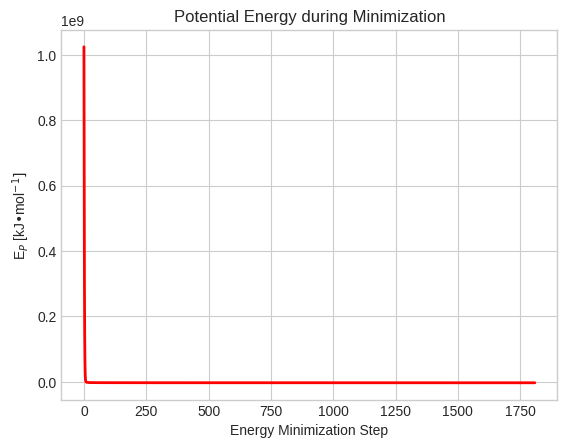

In [13]:
#@title ### 4. Plot the change in potential energy of the system
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('em_potential.xvg')

plt.title('Potential Energy during Minimization')
plt.xlabel('Energy Minimization Step')
plt.ylabel(r'E$_P$ [kJ•mol$^{-1}]$')
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red')
plt.show()

In [14]:
#@title ### 5. Downloading an MD parameter file and running an NVT equilibration
%%time
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/nvt.mdp

#Using grompp to prepare our NVT equilibration MD
source /content/gromacs/bin/GMXRC
gmx grompp -f nvt.mdp -c em.gro -r em.gro -p topol.top -o nvt.tpr -quiet

#Run our NVT equilibration MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm nvt -nb gpu -quiet

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:   296    Protein residues
There are: 60156      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.097 nm
Set rlist, assuming 4x4 atom pair-list, to 1.225 nm, buffer size 0.025 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 80x80x80, spacing 0.154 0.154 0.154
This run will generate roughly 104 Mb of data


--2023-08-04 06:52:01--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/nvt.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2464 (2.4K) [text/plain]
Saving to: ‘nvt.mdp’

     0K ..                                                    100% 45.9M=0s

2023-08-04 06:52:01 (45.9 MB/s) - ‘nvt.mdp’ saved [2464/2464]

Setting the LD random seed to -122036689
Generated 2145 of the 2145 non-bonded parameter combinations
Generating 1-4 interactions: fudge = 0.5
Generated 2145 of the 2145 1-4 parameter combinations
Excluding 3 bonded neighbours molecule type 'Protein_chain_A'
Excluding 2 bonded neighbours molecule type 'SOL'
Excluding 1 bonded neighbours molecule type 'NA'
Setting gen_seed to -16867745
Velocities were taken from a Maxwell distribution 

CPU times: user 619 ms, sys: 86.2 ms, total: 706 ms
Wall time: 2min 32s


In [15]:
#@title ### 6. Extract the change in temperature during the NVT equilibration
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Temperature" > options
echo " " >> options

#Using energy to extract the temperature of the system during the NVT equil MD
gmx energy -f nvt.edr -o nvt_temp.xvg -xvg none -quiet < options


Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 1 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                  299.74       0.27     3.4714    1.41059  (K)


Opened nvt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pres.-DC        18  Pressure        19  Constr.-rmsd    20  Vir-XX        
 21  Vir-XY          22  Vir-XZ          23  Vir-YX          24  Vir-YY        
 25  Vir-YZ          26  Vir-ZX          27  Vir-ZY          28  Vir-ZZ        
 29  Pres-XX         30  Pres-XY         31  Pres-XZ         32  Pres-YX       
 33  Pres-YY         34  Pres-YZ         35  Pres-ZX         36  Pres-ZY  

<ipython-input-16-6582e63f4ab2>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


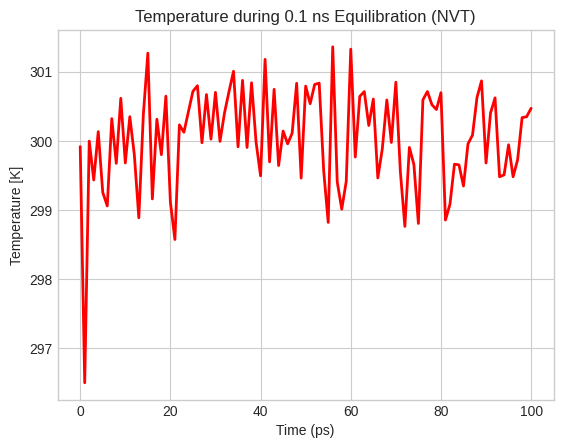

In [16]:
#@title ### 7. Plotting the change in temperature of the system during the NVT equilibration
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text file containing this information
data = np.loadtxt('nvt_temp.xvg')

plt.title('Temperature during 0.1 ns Equilibration (NVT)')
plt.xlabel('Time (ps)')
plt.ylabel('Temperature [K]')
plt.plot(data[:,0], data[:,1], linestyle='solid', linewidth='2', color='red')
plt.show()

In [17]:
#@title ### 8. Downloading an MD parameter file and running an NPT equilibration
%%time
%%bash
wget https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/npt.mdp

#Using grompp to prepare our NPT equilibration MD
source /content/gromacs/bin/GMXRC
gmx grompp -f npt.mdp -c nvt.gro -r nvt.gro -t nvt.cpt -p topol.top -o npt.tpr

#Run our NPT equilibration MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm npt -nb gpu

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:   296    Protein residues
There are: 60156      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.297 nm, buffer size 0.097 nm
Set rlist, assuming 4x4 atom pair-list, to 1.225 nm, buffer size 0.025 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 80x80x80, spacing 0.154 0.154 0.154
This run will generate roughly 104 Mb of data


--2023-08-04 06:54:34--  https://raw.githubusercontent.com/pb3lab/ibm3202/master/files/npt.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2687 (2.6K) [text/plain]
Saving to: ‘npt.mdp’

     0K ..                                                    100% 32.6M=0s

2023-08-04 06:54:34 (32.6 MB/s) - ‘npt.mdp’ saved [2687/2687]

                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupino

CPU times: user 594 ms, sys: 83.5 ms, total: 677 ms
Wall time: 2min 29s


In [18]:
#@title ### 9. Extract the change in pressure and density during the NPT equilibration
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Pressure" > options
echo "Density" >> options
echo " "

#Using energy to extract the pressure and density of the system during the NPT equil MD
gmx energy -f npt.edr -o npt_press_dens.xvg -xvg none -quiet < options

 

Statistics over 50001 steps [ 0.0000 through 100.0000 ps ], 2 data sets
All statistics are over 501 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                    2.44736       0.84    70.7329    1.16562  (bar)
Density                      1005.8       0.28    1.84103    1.15758  (kg/m^3)


Opened npt.edr as single precision energy file

Select the terms you want from the following list by
selecting either (part of) the name or the number or a combination.
End your selection with an empty line or a zero.
-------------------------------------------------------------------
  1  Bond             2  Angle            3  Proper-Dih.      4  Improper-Dih. 
  5  LJ-14            6  Coulomb-14       7  LJ-(SR)          8  Disper.-corr. 
  9  Coulomb-(SR)    10  Coul.-recip.    11  Position-Rest.  12  Potential     
 13  Kinetic-En.     14  Total-Energy    15  Conserved-En.   16  Temperature   
 17  Pres.-DC        18  Pressure        19  Constr.-rmsd    20  Box-X         
 21  Box-Y           22  Box-Z           23  Volume          24  Density       
 25  pV              26  Enthalpy        27  Vir-XX          28  Vir-XY        
 29  Vir-XZ          30  Vir-YX          31  Vir-YY          32  Vir-YZ        
 33  Vir-ZX          34  Vir-ZY          35  Vir-ZZ          36  Pres-XX  

<ipython-input-19-628984991ab1>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


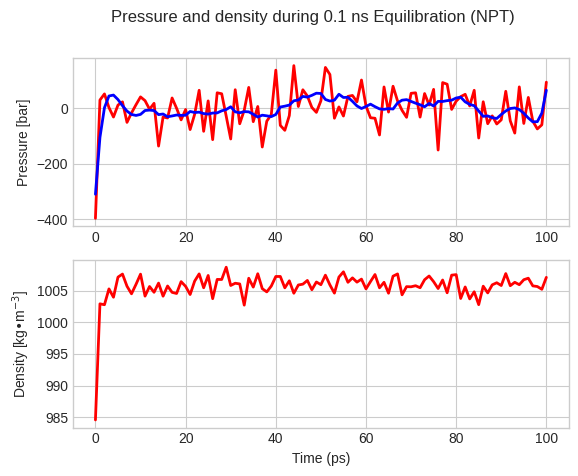

In [19]:
#@title ### 10. Plotting the change in pressure and density of the system during the NPT equilibration
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

#Reading the text files containing this information
data1 = np.loadtxt('npt_press_dens.xvg')
data2 = np.loadtxt('npt_press_dens.xvg')

fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Pressure and density during 0.1 ns Equilibration (NPT)')

ax1.set(ylabel='Pressure [bar]')
#ax1.ylim(-250,250)

ax2.set(xlabel='Time (ps)', ylabel='Density [kg•m$^{-3}$]')
#ax2.ylim(1000,1020)

#Smoothing using Savitzky-Golay
from scipy.signal import savgol_filter
yhat = savgol_filter(data1[:,1], 21, 5)

#Plot raw data and spline interpolation
ax1.plot(data1[:,0], data1[:,1], linestyle='solid', linewidth='2', color='red')
ax1.plot(data1[:,0], yhat, linestyle='solid', linewidth='2', color='blue')
ax2.plot(data2[:,0], data2[:,2], linestyle='solid', linewidth='2', color='red')

plt.show()

In [20]:
#@title ### 1. Downloading an MD parameter file and runninng a production MD simulation
%%time
%%bash
wget https://raw.githubusercontent.com/GloomyCourt/MD-dat/main/MD_01.mdp

#Using grompp to prepare our production MD
source /content/gromacs/bin/GMXRC
gmx grompp -f MD_01.mdp -c npt.gro -t npt.cpt -p topol.top -o md_1.tpr

#Run our production MD
source /content/gromacs/bin/GMXRC
gmx mdrun -deffnm md_1 -nb gpu

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Analysing residue names:
There are:   296    Protein residues
There are: 60156      Water residues
There are:     1        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.036 nm, buffer size 0.036 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 80x80x80, spacing 0.153 0.153 0.153
This run will generate roughly 901 Mb of data


--2023-08-04 06:57:05--  https://raw.githubusercontent.com/GloomyCourt/MD-dat/main/MD_01.mdp
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2749 (2.7K) [text/plain]
Saving to: ‘MD_01.mdp’

     0K ..                                                    100% 51.6M=0s

2023-08-04 06:57:05 (51.6 MB/s) - ‘MD_01.mdp’ saved [2749/2749]

                      :-) GROMACS - gmx grompp, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupi

CPU times: user 46.1 s, sys: 5.71 s, total: 51.8 s
Wall time: 3h 22min 41s


In [21]:
#@title ### 2. Removing the solvent from our MD simulation
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Protein" > options
echo "Protein" >> options
echo " "

#Using trjconv to extract only the protein atoms from the simulation trajectory
#and also recenter the protein if its atoms crossed the periodic boundaries
gmx trjconv -s md_1.tpr -f md_1.xtc -o md_traj01.pdb -pbc mol -center -quiet < options

 
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Selected 1: 'Protein'
Select group for output
Selected 1: 'Protein'


Will write pdb: Protein data bank file
Reading file md_1.tpr, VERSION 2020.6 (single precision)
Reading file md_1.tpr, VERSION 2020.6 (single precision)
Group     0 (         System) has 184926 elements
Group     1 (        Protein) has  4457 elements
Group     2 (      Protein-H) has  2272 elements
Group     3 (        C-alpha) has   296 elements
Group     4 (       Backbone) has   888 elements
Group     5 (      MainChain) has  1185 elements
Group     6 (   MainChain+Cb) has  1454 elements
Group     7 (    MainChain+H) has  1449 elements
Group     8 (      SideChain) has  3008 elements
Group     9 (    SideChain-H) has  1087 elements
Group    10 (    Prot-Masses) has  4457 elements
Group    11 (    non-Protein) has 180469 elements
Group    12 (          Water) has 180468 elements
Group    13 (            SOL) has 180468 elements
Group    14 (      non-Water) has  4458 elements
Group    15 (            Ion) has     1 elements
Group    16 (             NA) has     1 elements
Group    1

In [22]:
# copy it there
!cp /content/md_1.xtc /content/drive/MyDrive/MDS

In [23]:
# copy it there
!cp /content/md_1.log /content/drive/MyDrive/MDS

In [24]:
# copy it there
!cp /content/md_1.gro /content/drive/MyDrive/MDS

In [25]:
# copy it there
!cp /content/md_1.tpr /content/drive/MyDrive/MDS

In [26]:
# copy it there
!cp /content/md_traj01.pdb /content/drive/MyDrive/MDS

cp: cannot stat '/content/md_traj01.pdb': No such file or directory


In [27]:
# copy it there
!cp /content/md_1.cpt /content/drive/MyDrive/MDS

In [28]:
# copy it there
!cp /content/md_1.cpt /content/drive/MyDrive/MDS

In [ ]:
from google.colab import files
files.download("/content/md_1.xtc")

In [ ]:
from google.colab import files
files.download("/content/md_1.log")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("/content/md_1.gro")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("/content/md_1.tpr")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
files.download("/content/md_traj.pdb")

In [29]:
%%time
%%bash
source /content/gromacs/bin/GMXRC
gmx convert-tpr -s md_1.tpr -extend 10000 -o md_2.tpr

Extending remaining runtime of by 10000 ps (now 10000000 steps)


                   :-) GROMACS - gmx convert-tpr, 2020.6 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:
   

CPU times: user 4.3 ms, sys: 0 ns, total: 4.3 ms
Wall time: 73.9 ms


In [ ]:
%%bash
source /content/gromacs/bin/GMXRC
gmx mdrun -v -deffnm md_2 -cpi md_1.cpt -noappend

In [ ]:
#@title ### 2. Removing the solvent from our MD simulation
%%bash
source /content/gromacs/bin/GMXRC

#This is a trick to provide interactive options to gmx
echo "Protein" > options
echo "Protein" >> options
echo " "

#Using trjconv to extract only the protein atoms from the simulation trajectory
#and also recenter the protein if its atoms crossed the periodic boundaries
gmx trjconv -s md_1.tpr -f md_1.xtc -o md_traj.pdb -pbc mol -center -quiet < options

In [1]:
# mount it
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [35]:

# copy it there
!cp /content/traj_comp.part0002.xtc /content/drive/MyDrive/MDS

Mounted at /content/drive


# Instructions <a name="Instructions"></a>
**Quick start**
1. Paste your protein sequence(s) in the input field.
2. Press "Runtime" -> "Run all".
3. The pipeline consists of 5 steps. The currently running step is indicated by a circle with a stop sign next to it.

**Result zip file contents**

1. PDB formatted structures sorted by avg. pLDDT and complexes are sorted by pTMscore. (unrelaxed and relaxed if `use_amber` is enabled).
2. Plots of the model quality.
3. Plots of the MSA coverage.
4. Parameter log file.
5. A3M formatted input MSA.
6. A `predicted_aligned_error_v1.json` using [AlphaFold-DB's format](https://alphafold.ebi.ac.uk/faq#faq-7) and a `scores.json` for each model which contains an array (list of lists) for PAE, a list with the average pLDDT and the pTMscore.
7. BibTeX file with citations for all used tools and databases.

At the end of the job a download modal box will pop up with a `jobname.result.zip` file. Additionally, if the `save_to_google_drive` option was selected, the `jobname.result.zip` will be uploaded to your Google Drive.

**MSA generation for complexes**

For the complex prediction we use unpaired and paired MSAs. Unpaired MSA is generated the same way as for the protein structures prediction by searching the UniRef100 and environmental sequences three iterations each.

The paired MSA is generated by searching the UniRef100 database and pairing the best hits sharing the same NCBI taxonomic identifier (=species or sub-species). We only pair sequences if all of the query sequences are present for the respective taxonomic identifier.

**Using a custom MSA as input**

To predict the structure with a custom MSA (A3M formatted): (1) Change the `msa_mode`: to "custom", (2) Wait for an upload box to appear at the end of the "MSA options ..." box. Upload your A3M. The first fasta entry of the A3M must be the query sequence without gaps.

It is also possilbe to proide custom MSAs for complex predictions. Read more about the format [here](https://github.com/sokrypton/ColabFold/issues/76).

As an alternative for MSA generation the [HHblits Toolkit server](https://toolkit.tuebingen.mpg.de/tools/hhblits) can be used. After submitting your query, click "Query Template MSA" -> "Download Full A3M". Download the A3M file and upload it in this notebook.

**PDB100** <a name="pdb100"></a>

As of 23/06/08, we have transitioned from using the PDB70 to a 100% clustered PDB, the PDB100. The construction methodology of PDB100 differs from that of PDB70.

The PDB70 was constructed by running each PDB70 representative sequence through [HHblits](https://github.com/soedinglab/hh-suite) against the [Uniclust30](https://uniclust.mmseqs.com/). On the other hand, the PDB100 is built by searching each PDB100 representative structure with [Foldseek](https://github.com/steineggerlab/foldseek) against the [AlphaFold Database](https://alphafold.ebi.ac.uk).

To maintain compatibility with older Notebook versions and local installations, the generated files and API responses will continue to be named "PDB70", even though we're now using the PDB100.

**Using custom templates** <a name="custom_templates"></a>

To predict the structure with a custom template (PDB or mmCIF formatted): (1) change the `template_mode` to "custom" in the execute cell and (2) wait for an upload box to appear at the end of the "Input Protein" box. Select and upload your templates (multiple choices are possible).

* Templates must follow the four letter PDB naming with lower case letters.

* Templates in mmCIF format must contain `_entity_poly_seq`. An error is thrown if this field is not present. The field `_pdbx_audit_revision_history.revision_date` is automatically generated if it is not present.

* Templates in PDB format are automatically converted to the mmCIF format. `_entity_poly_seq` and `_pdbx_audit_revision_history.revision_date` are automatically generated.

If you encounter problems, please report them to this [issue](https://github.com/sokrypton/ColabFold/issues/177).

**Comparison to the full AlphaFold2 and AlphaFold2 Colab**

This notebook replaces the homology detection and MSA pairing of AlphaFold2 with MMseqs2. For a comparison against the [AlphaFold2 Colab](https://colab.research.google.com/github/deepmind/alphafold/blob/main/notebooks/AlphaFold.ipynb) and the full [AlphaFold2](https://github.com/deepmind/alphafold) system read our [paper](https://www.nature.com/articles/s41592-022-01488-1).

**Troubleshooting**
* Check that the runtime type is set to GPU at "Runtime" -> "Change runtime type".
* Try to restart the session "Runtime" -> "Factory reset runtime".
* Check your input sequence.

**Known issues**
* Google Colab assigns different types of GPUs with varying amount of memory. Some might not have enough memory to predict the structure for a long sequence.
* Your browser can block the pop-up for downloading the result file. You can choose the `save_to_google_drive` option to upload to Google Drive instead or manually download the result file: Click on the little folder icon to the left, navigate to file: `jobname.result.zip`, right-click and select \"Download\" (see [screenshot](https://pbs.twimg.com/media/E6wRW2lWUAEOuoe?format=jpg&name=small)).

**Limitations**
* Computing resources: Our MMseqs2 API can handle ~20-50k requests per day.
* MSAs: MMseqs2 is very precise and sensitive but might find less hits compared to HHblits/HMMer searched against BFD or MGnify.
* We recommend to additionally use the full [AlphaFold2 pipeline](https://github.com/deepmind/alphafold).

**Description of the plots**
*   **Number of sequences per position** - We want to see at least 30 sequences per position, for best performance, ideally 100 sequences.
*   **Predicted lDDT per position** - model confidence (out of 100) at each position. The higher the better.
*   **Predicted Alignment Error** - For homooligomers, this could be a useful metric to assess how confident the model is about the interface. The lower the better.

**Bugs**
- If you encounter any bugs, please report the issue to https://github.com/sokrypton/ColabFold/issues

**License**

The source code of ColabFold is licensed under [MIT](https://raw.githubusercontent.com/sokrypton/ColabFold/main/LICENSE). Additionally, this notebook uses the AlphaFold2 source code and its parameters licensed under [Apache 2.0](https://raw.githubusercontent.com/deepmind/alphafold/main/LICENSE) and [CC BY 4.0](https://creativecommons.org/licenses/by-sa/4.0/) respectively. Read more about the AlphaFold license [here](https://github.com/deepmind/alphafold).

**Acknowledgments**
- We thank the AlphaFold team for developing an excellent model and open sourcing the software.

- [KOBIC](https://kobic.re.kr) and [Söding Lab](https://www.mpinat.mpg.de/soeding) for providing the computational resources for the MMseqs2 MSA server.

- Richard Evans for helping to benchmark the ColabFold's Alphafold-multimer support.

- [David Koes](https://github.com/dkoes) for his awesome [py3Dmol](https://3dmol.csb.pitt.edu/) plugin, without whom these notebooks would be quite boring!

- Do-Yoon Kim for creating the ColabFold logo.

- A colab by Sergey Ovchinnikov ([@sokrypton](https://twitter.com/sokrypton)), Milot Mirdita ([@milot_mirdita](https://twitter.com/milot_mirdita)) and Martin Steinegger ([@thesteinegger](https://twitter.com/thesteinegger)).
